# Birch clustering algorithm comparison

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from birch import Birch as myBirch

In [2]:
def run_clustering(X, y_true, true_k):
    results = {}

    # --- My Birch ---
    start = time.perf_counter()
    mybirch = myBirch(branching_factor=50, leaf_size=50, cluster_method='agglomerative')
    labels = mybirch.fit_predict(X, n_clusters=true_k)
    elapsed = time.perf_counter() - start
    results['Birch'] = {
        'labels': labels,
        'time': elapsed,
        'nmi': normalized_mutual_info_score(y_true, labels)
    }

    # # --- Birch Sklearn ---
    # start = time.perf_counter()
    # birch = Birch(threshold=0.1, n_clusters=true_k) # sklearn implementation
    # labels = birch.fit_predict(X)
    # elapsed = time.perf_counter() - start
    # results['Birch_Sklearn'] = {
    #     'labels': labels,
    #     'time': elapsed,
    #     'nmi': normalized_mutual_info_score(y_true, labels)
    # }

    # --- KMeans ---
    start = time.perf_counter()
    kmeans = KMeans(n_clusters=true_k, init='k-means++', n_init=10, random_state=0)
    labels = kmeans.fit_predict(X)
    elapsed = time.perf_counter() - start
    results['KMeans'] = {
        'labels': labels,
        'time': elapsed,
        'nmi': normalized_mutual_info_score(y_true, labels)
    }


    # # --- MiniBatchKMeans ---
    # start = time.perf_counter()
    # mini = MiniBatchKMeans(n_clusters=true_k, batch_size=1024, random_state=0)
    # labels = mini.fit_predict(X)
    # elapsed = time.perf_counter() - start
    # results['MiniBatchKMeans'] = {
    #     'labels': labels,
    #     'time': elapsed,
    #     'nmi': normalized_mutual_info_score(y_true, labels)
    # }

    # --- Agglomerative Clustering ---
    start = time.perf_counter()
    from sklearn.cluster import AgglomerativeClustering
    agglomerative = AgglomerativeClustering(n_clusters=true_k, linkage='average')
    X_agglomerative = X
    if X.shape[0] > 5000:
        # Subsample for large datasets
        np.random.seed(0)
        indices = np.random.choice(X.shape[0], size=5000, replace=False)
        X_agglomerative = X[indices]
    labels_agglomerative = agglomerative.fit_predict(X_agglomerative)
    # Compute centroids of clusters
    agglomerative.cluster_centers_ = np.array([
        X_agglomerative[labels_agglomerative == k].mean(axis=0)
        for k in range(true_k)
    ])
    # Find closest cluster for each point in original data
    labels = np.empty(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        if X.shape[0] > 5000:
            dists = np.linalg.norm(agglomerative.cluster_centers_ - X[i], axis=1)
            labels[i] = np.argmin(dists)
        else:
            dists = np.linalg.norm(agglomerative.cluster_centers_ - X[i], axis=1)
            labels[i] = np.argmin(dists)

    elapsed = time.perf_counter() - start
    results['AgglomerativeClustering'] = {
        'labels': labels,
        'time': elapsed,
        'nmi': normalized_mutual_info_score(y_true, labels)
    }

    # --- DBSCAN ---
    # eps MUST be smaller than inter-cluster spacing
    start = time.perf_counter()
    dbscan = DBSCAN()
    labels = dbscan.fit_predict(X)
    elapsed = time.perf_counter() - start
    # ignore noise (-1) when computing NMI
    mask = labels != -1
    nmi = normalized_mutual_info_score(y_true[mask], labels[mask]) if mask.any() else 0.0
    results['DBSCAN'] = {
        'labels': labels,
        'time': elapsed,
        'nmi': nmi
    }

    return results

In [3]:
def plot_results(X, results, size):
    fig, axes = plt.subplots(1, len(results), figsize=(18, 5))

    for ax, (name, res) in zip(axes, results.items()):
        ax.scatter(X[:, 0], X[:, 1], c=res['labels'], s=size, cmap='nipy_spectral')
        ax.set_title(
            f"{name}\n"
            f"time = {res['time']:.3f}s\n"
            f"NMI = {res['nmi']:.3f}"
        )
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

For each dataset I perform the following measurements:
- I apply the clustering algorithms (Kmeans with kmeans++ initialization, Mini batch kmeans, DBSCAN)
- I measure the execution time
- I compare visually the plots (do some clustering algorithms only find convex clusters?)
- I compute the normalized mutual information w.r.t. the ground truth

## Grid data (convex clusters)

Dataset size: 100000 samples


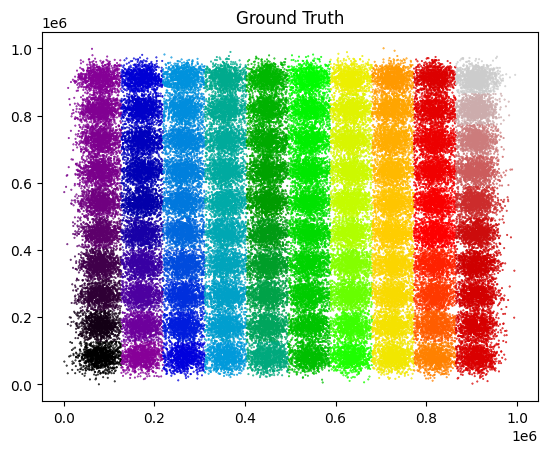

In [4]:
data = pd.read_csv('data/birch1.txt', sep=r"\s+", header=None).to_numpy()
labels = pd.read_csv('data/birch1_labels.txt', sep=r"\s+", header=None)
y_true = labels.to_numpy().flatten()
X = (data - data.mean(0))/data.std(0)
true_k = 100
size = 0.2
print(f"Dataset size: {data.shape[0]} samples")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()

CFTree has cfs 3001: it is too big! Increasing threshold from 0.0 to 0.0022411956366678422
CFTree has cfs 3001: it is too big! Increasing threshold from 0.0022411956366678422 to 0.005313411461731118
CFTree has cfs 3001: it is too big! Increasing threshold from 0.005313411461731118 to 0.010440400060956978
CFTree has cfs 3001: it is too big! Increasing threshold from 0.010440400060956978 to 0.019581334884583173
CFTree has cfs 3001: it is too big! Increasing threshold from 0.019581334884583173 to 0.042142516266418455
The number of cfs in the leaves is 1504


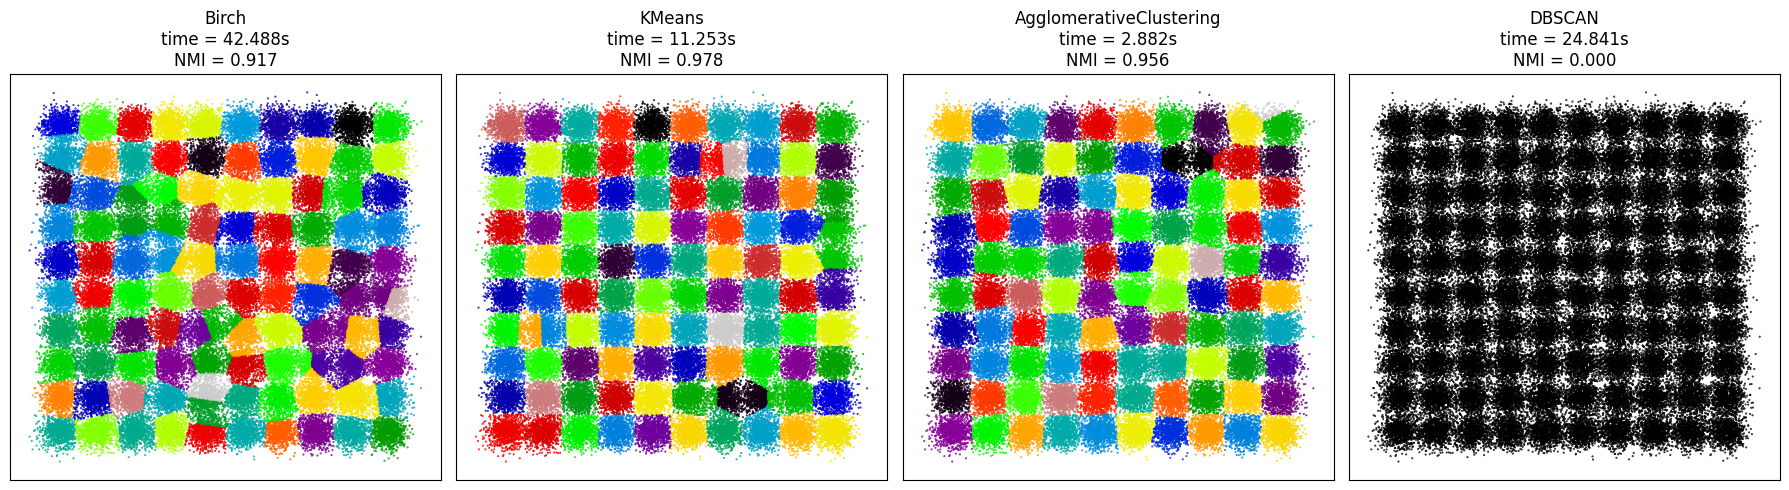

Birch           | time = 42.488s | NMI = 0.917
KMeans          | time = 11.253s | NMI = 0.978
AgglomerativeClustering | time = 2.882s | NMI = 0.956
DBSCAN          | time = 24.841s | NMI = 0.000


In [5]:
results = run_clustering(X, y_true, true_k)
plot_results(X, results, size)

for name, res in results.items():
    print(f"{name:15s} | time = {res['time']:.3f}s | NMI = {res['nmi']:.3f}")


## Spiral data (non convex clusters)

Dataset size: 312 samples


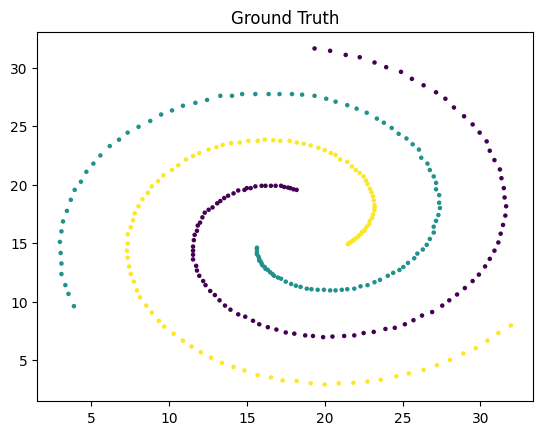

In [7]:
data = pd.read_csv('data/spiral.txt', sep=r"\s+", header=None).to_numpy()
X = (data - data.mean(0))/data.std(0)
labels = data[:,2]
y_true = labels.astype(int)
true_k = 3
size = 5
print(f"Dataset size: {data.shape[0]} samples")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true)
plt.title('Ground Truth')
plt.show()

The number of cfs in the leaves is 312


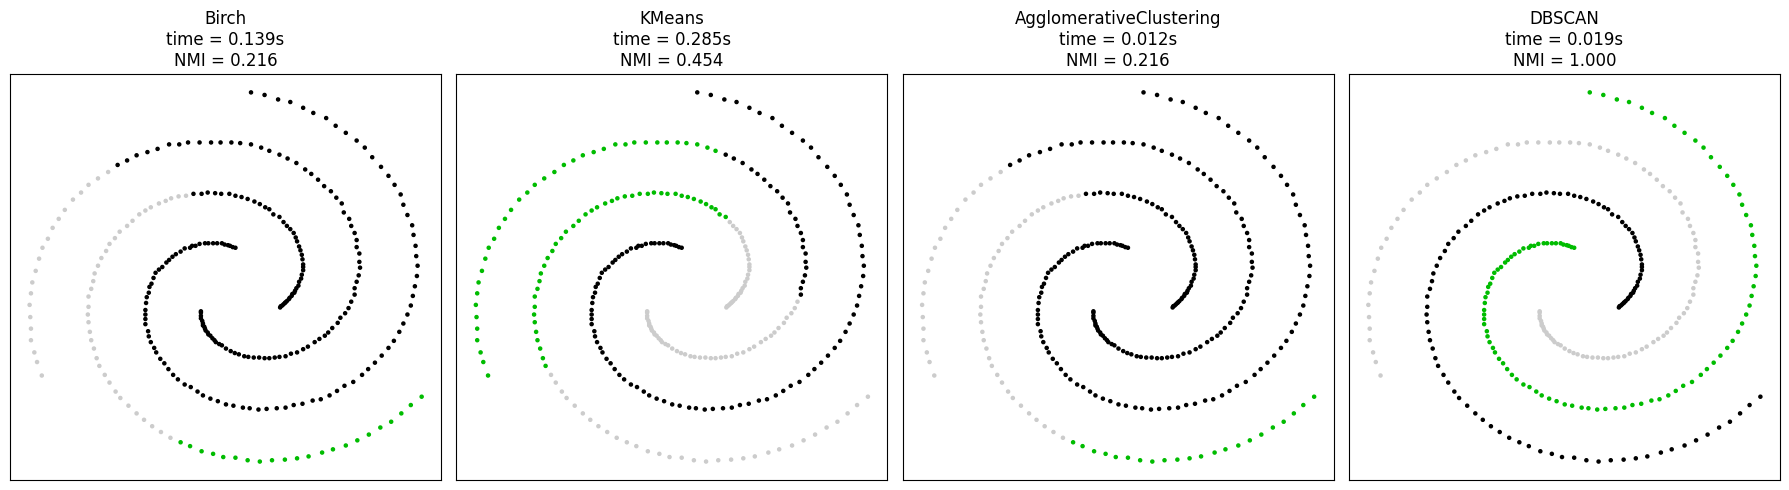

Birch           | time = 0.139s | NMI = 0.216
KMeans          | time = 0.285s | NMI = 0.454
AgglomerativeClustering | time = 0.012s | NMI = 0.216
DBSCAN          | time = 0.019s | NMI = 1.000


In [8]:
results = run_clustering(X, y_true, true_k)
plot_results(X, results, size)

for name, res in results.items():
    print(f"{name:15s} | time = {res['time']:.3f}s | NMI = {res['nmi']:.3f}")

## Sine curve data

Dataset size: 100000 points


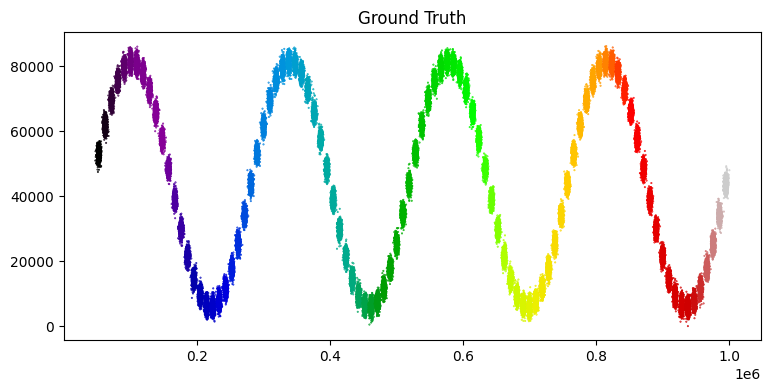

In [9]:
data = pd.read_csv('data/birch2.txt', sep=r"\s+", header=None).to_numpy()
X = (data - data.mean(0))/data.std(0)
labels = pd.read_csv('data/birch2_labels.txt', sep=r"\s+", header=None)
y_true = labels.to_numpy().flatten()
true_k = 100
size = 0.2
plt.figure(figsize=(9,4))
print(f"Dataset size: {data.shape[0]} points")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()

CFTree has cfs 3001: it is too big! Increasing threshold from 0.0 to 0.00031260005879996165
CFTree has cfs 3001: it is too big! Increasing threshold from 0.00031260005879996165 to 0.0010801008869288596
CFTree has cfs 3001: it is too big! Increasing threshold from 0.0010801008869288596 to 0.002156107868319345
CFTree has cfs 3001: it is too big! Increasing threshold from 0.002156107868319345 to 0.004056996775144248
CFTree has cfs 3001: it is too big! Increasing threshold from 0.004056996775144248 to 0.007462935678380091
The number of cfs in the leaves is 2992


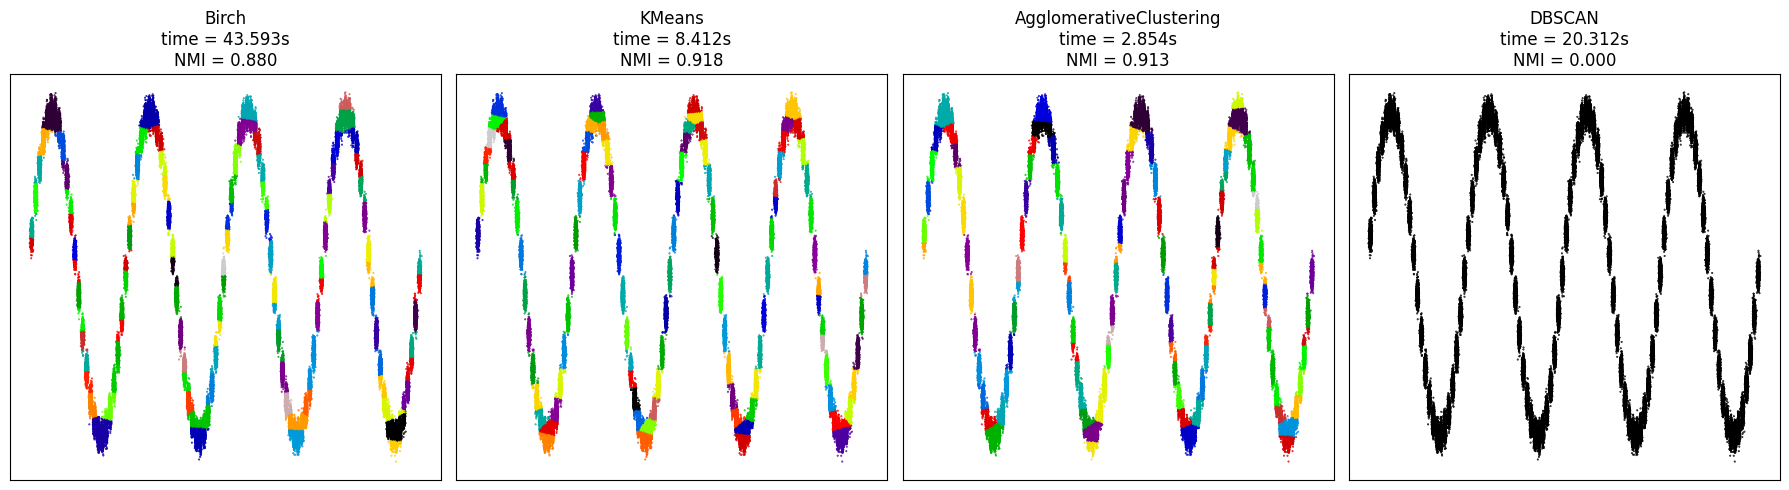

Birch           | time = 43.593s | NMI = 0.880
KMeans          | time = 8.412s | NMI = 0.918
AgglomerativeClustering | time = 2.854s | NMI = 0.913
DBSCAN          | time = 20.312s | NMI = 0.000


In [10]:
results = run_clustering(X, y_true, true_k)
plot_results(X, results, size)

for name, res in results.items():
    print(f"{name:15s} | time = {res['time']:.3f}s | NMI = {res['nmi']:.3f}")

## Blob clusters data

Dataset size: 105000 points


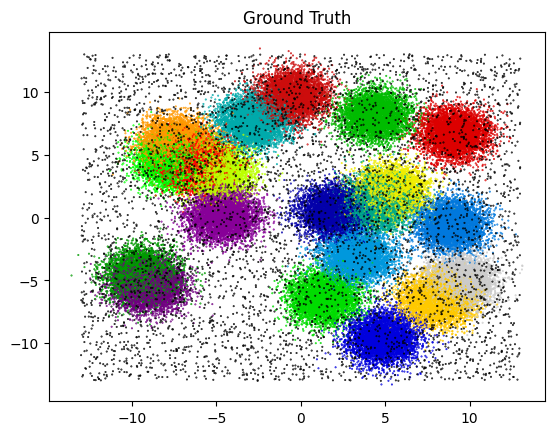

In [13]:
from sklearn.datasets import make_blobs
true_k = 20
data, y_true = make_blobs(n_samples=100000, centers=true_k, random_state=170)
noise = np.random.uniform(low=-13, high=13, size=(5000, 2))
data = np.vstack([data, noise])
X = np.vstack([X,noise])
X = (data - data.mean(0))/data.std(0)
y_true = np.hstack([y_true, [-1]*5000])  # label noise as -1
size = 0.2
print(f"Dataset size: {data.shape[0]} points")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()

CFTree has cfs 3001: it is too big! Increasing threshold from 0.0 to 0.009994405156549185
CFTree has cfs 3001: it is too big! Increasing threshold from 0.009994405156549185 to 0.027275487122669147
CFTree has cfs 3001: it is too big! Increasing threshold from 0.027275487122669147 to 0.045281501110162284
The number of cfs in the leaves is 2415


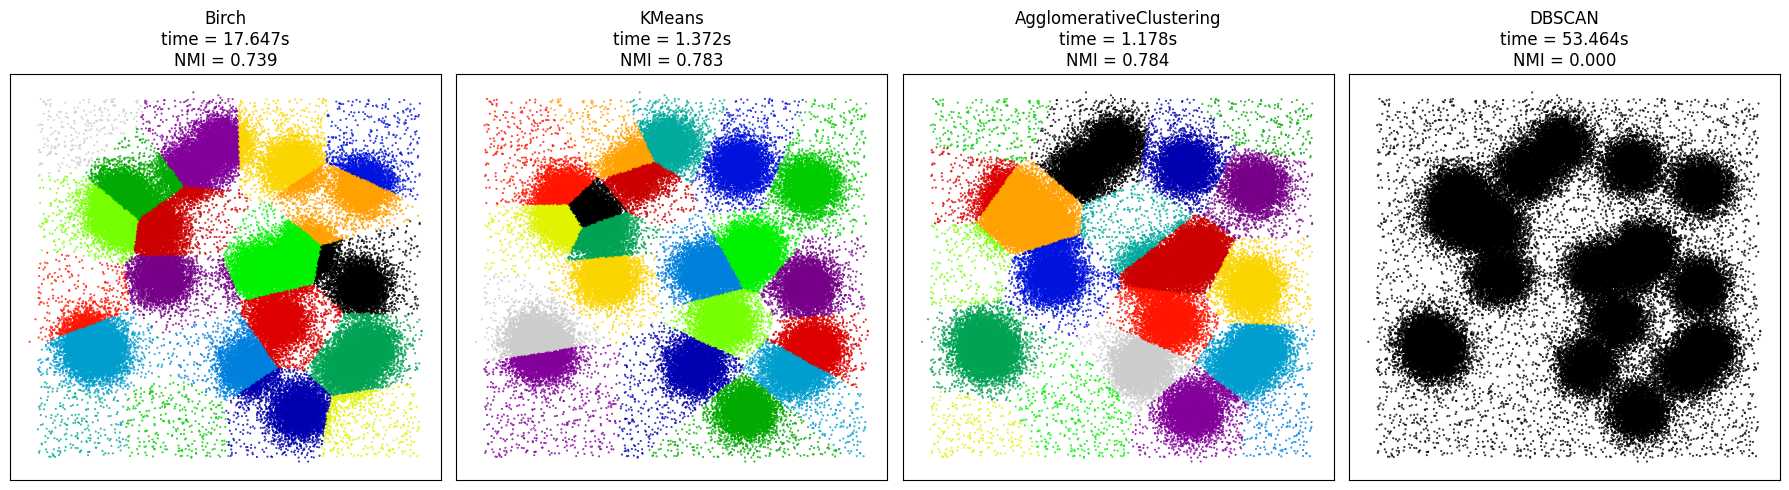

Birch           | time = 17.647s | NMI = 0.739
KMeans          | time = 1.372s | NMI = 0.783
AgglomerativeClustering | time = 1.178s | NMI = 0.784
DBSCAN          | time = 53.464s | NMI = 0.000


In [14]:
results = run_clustering(X, y_true, true_k)
plot_results(X, results, size)

for name, res in results.items():
    print(f"{name:15s} | time = {res['time']:.3f}s | NMI = {res['nmi']:.3f}")

## Random clusters data (there is no ground truth...)

Dataset size: 100000 points


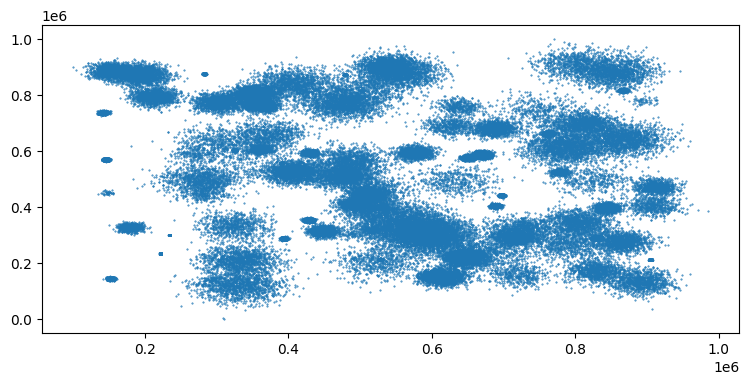

In [191]:
data = pd.read_csv('data/birch3.txt', sep=r"\s+", header=None).to_numpy()
X = (data - data.mean(0))/data.std(0)
true_k = 100
size = 0.2
plt.figure(figsize=(9,4))
print(f"Dataset size: {data.shape[0]} points")
plt.scatter(data[:, 0], data[:, 1], s=size)
plt.show()